
# NLP Model Handler with RAG and LLaMA-2

This notebook demonstrates the use of a Python class to handle interactions with the Retrieval-Augmented Generation (RAG) model and Facebook's LLaMA-2 Large Language Model. It also includes model efficiency metrics and graphs to illustrate performance.


## Step 1 : Install the required libraries and define the NLPModelHandler class

In [ ]:
## Importing Libraries
!pip install transformers
!pip install torch
!pip install matplotlib
!pip install torch datasets
!pip install faiss-cpu
!pip install faiss-gpu
!pip install sentencepiece
!pip install rouge
!pip install nltk
!pip install rouge-score

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import torch
from transformers import (
    RagTokenizer,
    RagRetriever,
    RagTokenForGeneration,
    AutoModelForCausalLM,
    AutoTokenizer,
)
import matplotlib.pyplot as plt
import time
from google.cloud import aiplatform


## Step 2 : Instantiate the NLPModelHandler class and load the models and load the wikipedia data for RAG Retriever training

In [43]:
## NLPModelHandler Class
# This class encapsulates methods for RAG and LLaMA-2 models.
from google.cloud import aiplatform

import matplotlib.pyplot as plt
import numpy as np
import nltk

# Make sure to download NLTK punkt tokenizer
nltk.download('punkt')

from rouge import Rouge
#Import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.translate.bleu_score import sentence_bleu
from sklearn.metrics.pairwise import cosine_similarity

class NLPModelHandler:

    def __init__(self):
        # Usage
        # RAG model initialization
        self.rag_tokenizer = RagTokenizer.from_pretrained("facebook/rag-token-nq")

        self.rag_retriever = RagRetriever.from_pretrained(
            "facebook/rag-token-nq", index_name="exact", use_dummy_dataset=True
        )
        self.rag_model = RagTokenForGeneration.from_pretrained(
            "facebook/rag-token-nq", retriever=self.rag_retriever
        )

        # LLaMA-2 model initialization
        project_id = "changecx-356309"
        location = "us-central1"
        vertex_ai_client = aiplatform.init(project=project_id, location=location)
        self.endpoint = aiplatform.Endpoint("1552882053349900288")


    def generate_rag_response(self, query):
        start_time = time.time()
        input_ids = self.rag_tokenizer(query, return_tensors="pt").input_ids
        generated_ids = self.rag_model.generate(input_ids)
        end_time = time.time()
        response_time = end_time - start_time
        response = self.rag_tokenizer.batch_decode(
            generated_ids, skip_special_tokens=True
        )[0]
        return response, response_time

    def generate_llama_response(self, prompt):
        start_time = time.time()
        # Request prediction from Vertex AI
        response = self.endpoint.predict(instances=[{"prompt": prompt,"max_tokens":500}])
        end_time = time.time()
        response_time = end_time - start_time

        # Extract and format the response
        if response.predictions:
            llama_response = response.predictions[0]  # Adjust based on how your model's output is structured
        else:
            llama_response = "No response"

        return llama_response, response_time

    def combined_response(self, rag_query):
        rag_answer, rag_time = self.generate_rag_response(rag_query)
        llama_prompt = (
            f"Summarize the following information in simple terms: {rag_answer}"
        )
        llama_response, llama_time = self.generate_llama_response(llama_prompt)
        total_time = rag_time + llama_time
        return llama_response, total_time

## Model Efficiency Metrics
    ### We'll define a function to test the models and plot their response times.
    def test_model_performance(self):
        queries = [
            "What is the deepest part of the ocean?",
            "Write a story about a space adventure.",
            "Explain quantum computing.",
        ]
        # Metrics
        rag_times = []
        llama_times = []
        combined_times = []
        rag_responses = []
        llama_responses = []
        combined_responses = []
        bleu_scores = []  # BLEU scores for combined responses
        similarity_scores = []  # Cosine similarity scores

        # Initialize TF-IDF Vectorizer
        vectorizer = TfidfVectorizer()

        for query in queries:
            # RAG model response
            rag_response_text, rag_time = self.generate_rag_response(query)
            rag_times.append(rag_time)
            rag_responses.append(rag_response_text)

            # LLaMA-2 model response
            llama_response_text, llama_time = self.generate_llama_response(query)
            llama_times.append(llama_time)
            llama_responses.append(llama_response_text)

            # Combined model response
            combined_response_text, combined_time = self.combined_response(query)
            combined_times.append(combined_time)
            combined_responses.append(combined_response_text)

            # Calculate BLEU Score
            reference = nltk.word_tokenize(query.lower())
            candidate = nltk.word_tokenize(combined_response_text.lower())
            bleu_score = sentence_bleu([reference], candidate)
            bleu_scores.append(bleu_score)

            # Calculate Cosine Similarity
            tfidf_matrix = vectorizer.fit_transform([query, combined_response_text])
            cosine_sim = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])
            similarity_scores.append(cosine_sim[0][0])

            print(f"BLEU Score: {bleu_score}")
            print(f"Cosine Similarity: {cosine_sim[0][0]}")

        rouge_scores = []  # ROUGE scores for combined responses

        rouge = Rouge()

        for i in range(len(queries)):
            # Calculate ROUGE Score
            scores = rouge.get_scores(combined_responses[i], queries[i])
            rouge_scores.append(scores[0])  # Assuming you want the first score
            print(f"ROUGE Score: {scores[0]}")

        return queries, rag_times, llama_times, combined_times, rag_responses, llama_responses, combined_responses, bleu_scores, similarity_scores, rouge_scores
### This notebook allows us to understand the efficiency and performance of RAG and LLaMA-2 models in different scenarios.

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Step 3 : Define the input text and query and tests

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizerFast'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'BartTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called fr

BLEU Score: 7.566995996800094e-232
Cosine Similarity: 0.05745520664831345
BLEU Score: 5.877175980056326e-232
Cosine Similarity: 0.0
BLEU Score: 4.869050800549907e-232
Cosine Similarity: 0.15608728300570923
ROUGE Score: {'rouge-1': {'r': 0.2857142857142857, 'p': 0.02564102564102564, 'f': 0.04705882201799312}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.2857142857142857, 'p': 0.02564102564102564, 'f': 0.04705882201799312}}
ROUGE Score: {'rouge-1': {'r': 0.16666666666666666, 'p': 0.006369426751592357, 'f': 0.012269937941209723}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.16666666666666666, 'p': 0.006369426751592357, 'f': 0.012269937941209723}}
ROUGE Score: {'rouge-1': {'r': 0.3333333333333333, 'p': 0.0072992700729927005, 'f': 0.014285713866326542}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.3333333333333333, 'p': 0.0072992700729927005, 'f': 0.014285713866326542}}


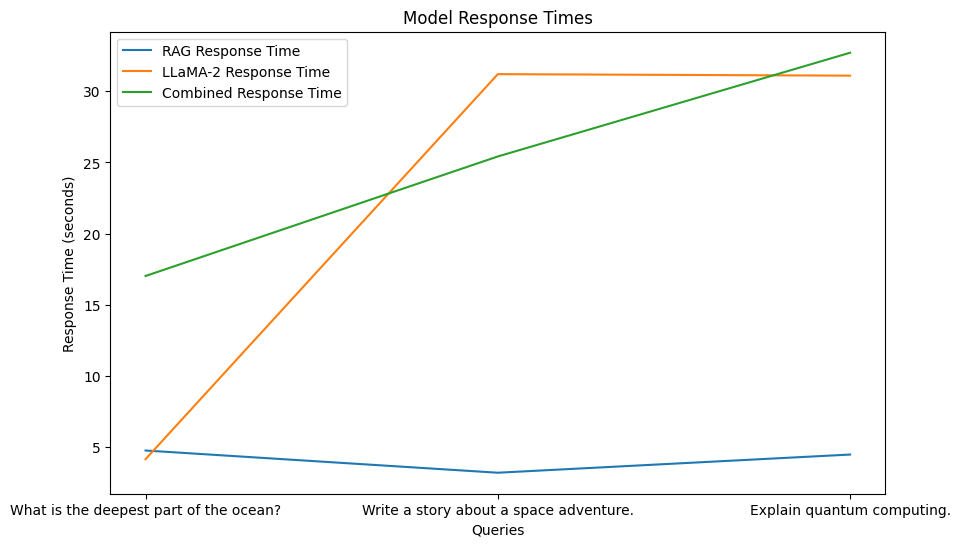

Going to show Responses 
 

RAG Responses: [' milwaukee deep', ' american psycho', ' general quantum states']
LLaMA-2 Responses: ['Prompt:\nWhat is the deepest part of the ocean?\nOutput:\nAnswer: The deepest part of the ocean is called the Challenger Deep, which is located in the Mariana Trench in the western Pacific Ocean. It has a maximum depth of approximately 36,000 feet (10,973 meters), making it the lowest point on Earth.', "Prompt:\nWrite a story about a space adventure.\nOutput:\n (1000 words or more)\n\nZara had always been fascinated by space. As a young girl, she would spend hours gazing up at the stars, dreaming of what lay beyond the reaches of planet Earth. As she grew older, her fascination only deepened, and she became determined to explore the galaxy for herself.\nAfter completing her education, Zara applied to join the prestigious StarExplorers program, a group of elite space travelers who had been tasked with mapping the furthest reaches of the cosmos. It was a high

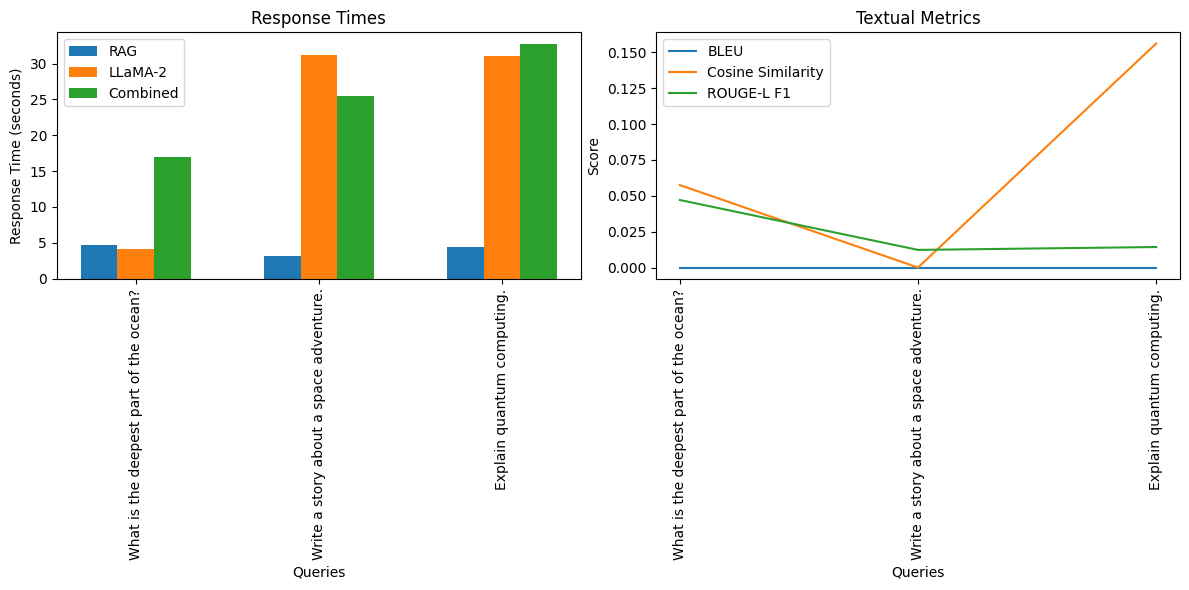

In [45]:
## Running the Tests
def plot_performance(queries, rag_times, llama_times, combined_times):
    plt.figure(figsize=(10, 6))
    plt.plot(queries, rag_times, label="RAG Response Time")
    plt.plot(queries, llama_times, label="LLaMA-2 Response Time")
    plt.plot(queries, combined_times, label="Combined Response Time")
    plt.xlabel("Queries")
    plt.ylabel("Response Time (seconds)")
    plt.title("Model Response Times")
    plt.legend()
    plt.show()

def plot_efficiency(queries, rag_times, llama_times, combined_times, bleu_scores, similarity_scores, rouge_scores):
    # Number of queries
    n = len(queries)

    # Time Metrics
    plt.figure(figsize=(12, 6))
    x = np.arange(n)
    plt.subplot(1, 2, 1)
    plt.bar(x - 0.2, rag_times, 0.2, label='RAG')
    plt.bar(x, llama_times, 0.2, label='LLaMA-2')
    plt.bar(x + 0.2, combined_times, 0.2, label='Combined')
    plt.xticks(x, queries, rotation='vertical')
    plt.xlabel('Queries')
    plt.ylabel('Response Time (seconds)')
    plt.title('Response Times')
    plt.legend()

    # Textual Metrics
    bleu = [score for score in bleu_scores]
    similarity = [score for score in similarity_scores]
    rouge_l = [score['rouge-l']['f'] for score in rouge_scores]  # Example: F1-score of ROUGE-L

    plt.subplot(1, 2, 2)
    plt.plot(queries, bleu, label='BLEU')
    plt.plot(queries, similarity, label='Cosine Similarity')
    plt.plot(queries, rouge_l, label='ROUGE-L F1')
    plt.xticks(rotation='vertical')
    plt.xlabel('Queries')
    plt.ylabel('Score')
    plt.title('Textual Metrics')
    plt.legend()

    plt.tight_layout()
    plt.show()

nlp_handler = NLPModelHandler()
queries, rag_times, llama_times, combined_times,rag_responses,llama_responses,combined_responses,bleu_scores, similarity_scores, rouge_scores = nlp_handler.test_model_performance()
plot_performance(queries, rag_times, llama_times, combined_times)
print(f"Going to show Responses \n \n")
print(f"RAG Responses: {rag_responses}")
print(f"LLaMA-2 Responses: {llama_responses}")
print(f"Combined Responses: {combined_responses}")
print(f"Going to Plot Response Efficiency \n \n")
plot_efficiency(queries, rag_times, llama_times, combined_times, bleu_scores, similarity_scores, rouge_scores)
